# Finetuning Segment Anything with `µsam`

This notebook shows how to use Segment Anything for Microscopy to fine-tune a Segment Anything Model (SAM) on an open-source data with multiple channels.

We use confocal microscopy images from the HPA Kaggle Challenge for protein identification (from [Ouyang et al.](https://doi.org/10.1038/s41592-019-0658-6)) in this notebook for the cell segmentation task. The functionalities shown here should work for your (microscopy) images too.

## Running this notebook

If you have an environment with `µsam` on your computer you can run this notebook in there. You can follow the [installation instructions](https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#installation) to install it on your computer.

You can also run this notebook in the cloud on [Kaggle Notebooks](https://www.kaggle.com/code/). This service offers free usage of a GPU to speed up running the code. The next cells will take care of the installation for you if you are using it.

In [1]:
# Check if we are running this notebook on kaggle, google colab or local compute resources.
import os
current_spot = os.getcwd()

if current_spot.startswith("/kaggle/working"):
    print("Kaggle says hi!")
    root_dir = "/kaggle/working"

elif current_spot.startswith("/content"):
    print("Google Colab says hi!")
    print(" NOTE: The scripts have not been tested on Google Colab, you might need to adapt the installations a bit.")
    root_dir = "/content"

    # You might need to install condacolab on Google Colab to be able to install packages using conda / mamba
    # !pip install -q condacolab
    # import condacolab
    # condacolab.install()

else:
    msg = "You are using a behind-the-scenes resource. Follow our installation instructions here:"
    msg += " https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#installation"
    print(msg)
    root_dir = ""  # overwrite to set the root directory, where the data, checkpoints, and all relevant stuff will be stored

Kaggle says hi!


### Installation

The next cells will install the `micro_sam` library on Kaggle Notebooks. **Please skip these cells and go to `Importing the libraries` if you are running the notebook on your own computer.**

In [2]:
!git clone --quiet https://github.com/computational-cell-analytics/micro-sam.git
tmp_dir = os.path.join(root_dir, "micro-sam")
!pip install --quiet $tmp_dir

In [3]:
!git clone --quiet https://github.com/constantinpape/torch-em.git
tmp_dir = os.path.join(root_dir, "torch-em")
!pip install --quiet $tmp_dir

In [4]:
!git clone --quiet https://github.com/constantinpape/elf.git
tmp_dir = os.path.join(root_dir, "elf")
!pip install --quiet $tmp_dir

Known Issues on **Kaggle Notebooks**:

1. `warning  libmamba Cache file "/opt/conda/pkgs/cache/2ce54b42.json" was modified by another program` (multiples lines of such warnings)
    - We have received this warning while testing this notebook on Kaggle. It does not lead to any issues while making use of the installed packages. You can proceed and ignore the warnings.

In [5]:
!mamba install -q -y -c conda-forge nifty affogato zarr z5py natsort
!pip uninstall -y --quiet qtpy  # qtpy is not supported in Kaggle / Google Colab, let's remove it to avoid errors.

warning  libmamba Cache file "/opt/conda/pkgs/cache/497deca9.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/09cdf8bf.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/c6f2354e.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/86b0f08d.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/c9ddbd6b.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/b121c3e7.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/d4808d92.json" was modified by another program
warning  libmamba Cache file "/opt/conda/pkgs/cache/223a346e.json" was modified by another program
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


### Importing the libraries

In [6]:
import os
from glob import glob
from typing import List
from natsort import natsorted
from IPython.display import FileLink

import imageio.v3 as imageio
from matplotlib import pyplot as plt
from skimage.measure import label as connected_components

import torch
from torch_em.data import datasets
from torch_em.util.debug import check_loader
from torch_em.util.util import get_random_colors

import micro_sam.training as sam_training
from micro_sam.training.util import normalize_to_8bit
from micro_sam.automatic_segmentation import get_predictor_and_segmenter, automatic_instance_segmentation

/opt/conda/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


### Let's download the dataset

First, we download the images and corresponding labels stored as `tif` files.

In [7]:
# Download the data into a directory
DATA_FOLDER = os.path.join(root_dir, "hpa")

downloader = "owncloud"  # Switch to 'drive' if the download fails at 'owncloud'

if downloader == "owncloud":
    URL = "https://owncloud.gwdg.de/index.php/s/IrzUcaMxQKVRLTs/download"
elif downloader == "drive":
    URL = "https://drive.google.com/uc?export=download&id=1EuBj2UkVTy2DRfKGltaFga5zuXHqVOvI"
else:
    raise ValueError(
        f"'{downloader}' is not a valid way to download. Please choose either 'owncloud' or 'drive'."
    )

CHECKSUM = "f2c41be1761cdd96635ee30bee9dcbdeda4ebe3ab3467ad410c28417d46cdaad"

os.makedirs(DATA_FOLDER, exist_ok=True)
if not os.path.exists(os.path.join(DATA_FOLDER, "train/images")):
    zip_path = os.path.join(DATA_FOLDER, "data.zip")

    if downloader == "owncloud":
        datasets.util.download_source(path=zip_path, url=URL, download=True, checksum=CHECKSUM)
    else:
        datasets.util.download_source_gdrive(path=zip_path, url=URL, download=True, checksum=CHECKSUM)

    datasets.util.unzip(zip_path=zip_path, dst=DATA_FOLDER)

# Get filepaths to the image data.
train_image_paths = natsorted(glob(os.path.join(DATA_FOLDER, "train", "images", "*.tif")))
val_image_paths = natsorted(glob(os.path.join(DATA_FOLDER, "val", "images", "*.tif")))
test_image_paths = natsorted(glob(os.path.join(DATA_FOLDER, "test", "images", "*.tif")))

# Get filepaths to the label data.
train_label_paths = natsorted(glob(os.path.join(DATA_FOLDER, "train", "labels", "*.tif")))
val_label_paths = natsorted(glob(os.path.join(DATA_FOLDER, "val", "labels", "*.tif")))

print(f"The inputs have been preprocessed and stored at: '{DATA_FOLDER}'")

Download https://owncloud.gwdg.de/index.php/s/IrzUcaMxQKVRLTs/download to /kaggle/working/hpa/data.zip: 100%|██████████| 1.23G/1.23G [01:29<00:00, 14.7MB/s]


Download successful and checksums agree.
The inputs have been preprocessed and stored at: '/kaggle/working/hpa'


### Let's understand our inputs' data structure.

In [8]:
for image_path, label_path in zip(train_image_paths, train_label_paths):  # Checking the inputs for the train split.
    image = imageio.imread(image_path)
    labels = imageio.imread(label_path)

    # The images should be of shape: H, W, 4 -> where, 4 is the number of channels.
    if (image.ndim == 3 and image.shape[-1] == 3) or image.ndim == 2:
        print(f"Inputs '{image.shape}' match the channel expectations.")
    else:
        print(f"Inputs '{image.shape}' must match the channel expectations (of either one or three channels).")

    # The labels should be of shape: H, W
    print(f"Shape of corresponding labels: '{labels.shape}'")

    break  # comment this line out in case you would like to verify the shapes for all inputs.

Inputs '(2048, 2048, 4)' must match the channel expectations (of either one or three channels).
Shape of corresponding labels: '(2048, 2048)'


Segment Anything accepts inputs of either 1 channel or 3 channels. To fine-tune Segment Anything on our data, we must select either 1 channel or 3 channels out of the 4 channels available.

Let's make the choice to choose the `microtubule` (first channel), `protein` (second channel) and `nuclei` (third channel) for finetuning Segment Anything.

In [9]:
# We remove the 'er' channel, i.e. the last channel.
def preprocess_inputs(image_paths: List[str]):
    for image_path in image_paths:
        image = imageio.imread(image_path)

        if image.ndim == 3 and image.shape[-1] == 4:  # Convert 4 channel inputs to 3 channels.
            image = image[..., :-1]
            imageio.imwrite(image_path, image)

preprocess_inputs(train_image_paths)
preprocess_inputs(val_image_paths)
preprocess_inputs(test_image_paths)

### Let's create the dataloaders

Our task is to segment cells in confocal microscopy images. The dataset comes from https://zenodo.org/records/4665863, and the dataloader has been implemented in [torch-em](https://github.com/constantinpape/torch-em/blob/main/torch_em/data/datasets/light_microscopy/hpa.py)

#### First, let's visualize how our samples look.

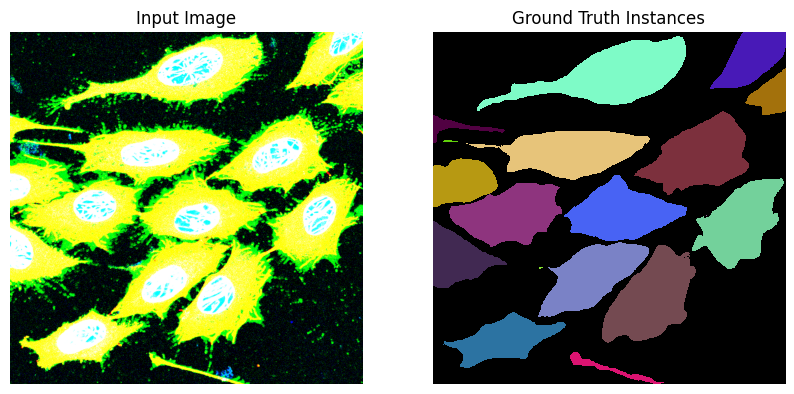

In [10]:
for image_path, label_path in zip(train_image_paths, train_label_paths):  # Visualize inputs for the train split.
    image = imageio.imread(image_path)
    labels = imageio.imread(label_path)

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(image)
    ax[0].set_title("Input Image")
    ax[0].axis("off")

    labels = connected_components(labels)
    ax[1].imshow(labels, cmap=get_random_colors(labels), interpolation="nearest")
    ax[1].set_title("Ground Truth Instances")
    ax[1].axis("off")

    plt.show()
    plt.close()

    break  # comment this out in case you want to visualize all the images

#### Next, let's create the dataloaders.

In [11]:
# micro_sam.training.default_sam_loader is a convenience function to build a torch dataloader from image data and labels for training segmentation models.
# This is wrapped around the 'torch_em.default_segmentation_loader'.
# It supports image data in various formats.
# Here, we load image data and corresponding labels by providing filepaths to the respective tif files that were download and preprocessed using the functionality above.
# Next, we create a list of filepaths for the image and label data by fetching all '*.tif' files in the respective directories.
# For more information, here is the documentation: https://github.com/constantinpape/torch-em/blob/main/torch_em/data/datasets/README.md
# Here is a detailed notebook on finetuning Segment Anything: https://github.com/computational-cell-analytics/micro-sam/blob/master/notebooks/sam_finetuning.ipynb

# Load images from tif stacks by setting `raw_key` and `label_key` to None.
raw_key, label_key = None, None

In [12]:
# The script below returns the train or val data loader for finetuning Segment Anything Model (SAM).
# The data loader must be a torch dataloader that returns `x, y` tensors,
# where `x` is the image data and `y` are the corresponding labels.
# The labels have to be in a label mask instance segmentation format.
# i.e. a tensor of the same spatial shape as `x`, with each object mask having its own ID.
# IMPORTANT: the ID 0 is reserved for backgroun, and the IDS must be consecutive.
# Here, we use `micro_sam.training.default_sam_loader` for creating the suitable data loader from
# the HPA data. You can either adapt this for your own data or write a suitable torch dataloader yourself.
# Here is a quickstart notebook to create your own dataloaders: https://github.com/constantinpape/torch-em/blob/main/notebooks/tutorial_create_dataloaders.ipynb

batch_size = 1  # the training batch size
patch_shape = (1024, 1024)  # the size of patches for training

# Train an additional convolutional decoder for end-to-end automatic instance segmentation
train_instance_segmentation = True

# The dataloader internally takes care of adding label transforms: i.e. used to convert the ground-truth
# labels to the desired instances for finetuning Segment Anythhing, or, to learn the foreground and distances
# to the object centers and object boundaries for automatic segmentation.

train_loader = sam_training.default_sam_loader(
    raw_paths=train_image_paths,
    raw_key=raw_key,
    label_paths=train_label_paths,
    label_key=label_key,
    is_seg_dataset=False,
    patch_shape=patch_shape,
    with_channels=True,
    with_segmentation_decoder=train_instance_segmentation,
    batch_size=batch_size,
    shuffle=True,
    raw_transform=normalize_to_8bit,
    n_samples=100,
)

val_loader = sam_training.default_sam_loader(
    raw_paths=val_image_paths,
    raw_key=raw_key,
    label_paths=val_label_paths,
    label_key=label_key,
    is_seg_dataset=False,
    patch_shape=patch_shape,
    with_channels=True,
    with_segmentation_decoder=train_instance_segmentation,
    batch_size=batch_size,
    raw_transform=normalize_to_8bit,
    shuffle=True,
)

/opt/conda/lib/python3.10/site-packages/torch_em/util/debug.py:39: UserWarning: Multi-channel input data is not yet supported, will only show channel 0 / 3
  warnings.warn(f"Multi-channel input data is not yet supported, will only show channel 0 / {x.shape[0]}")


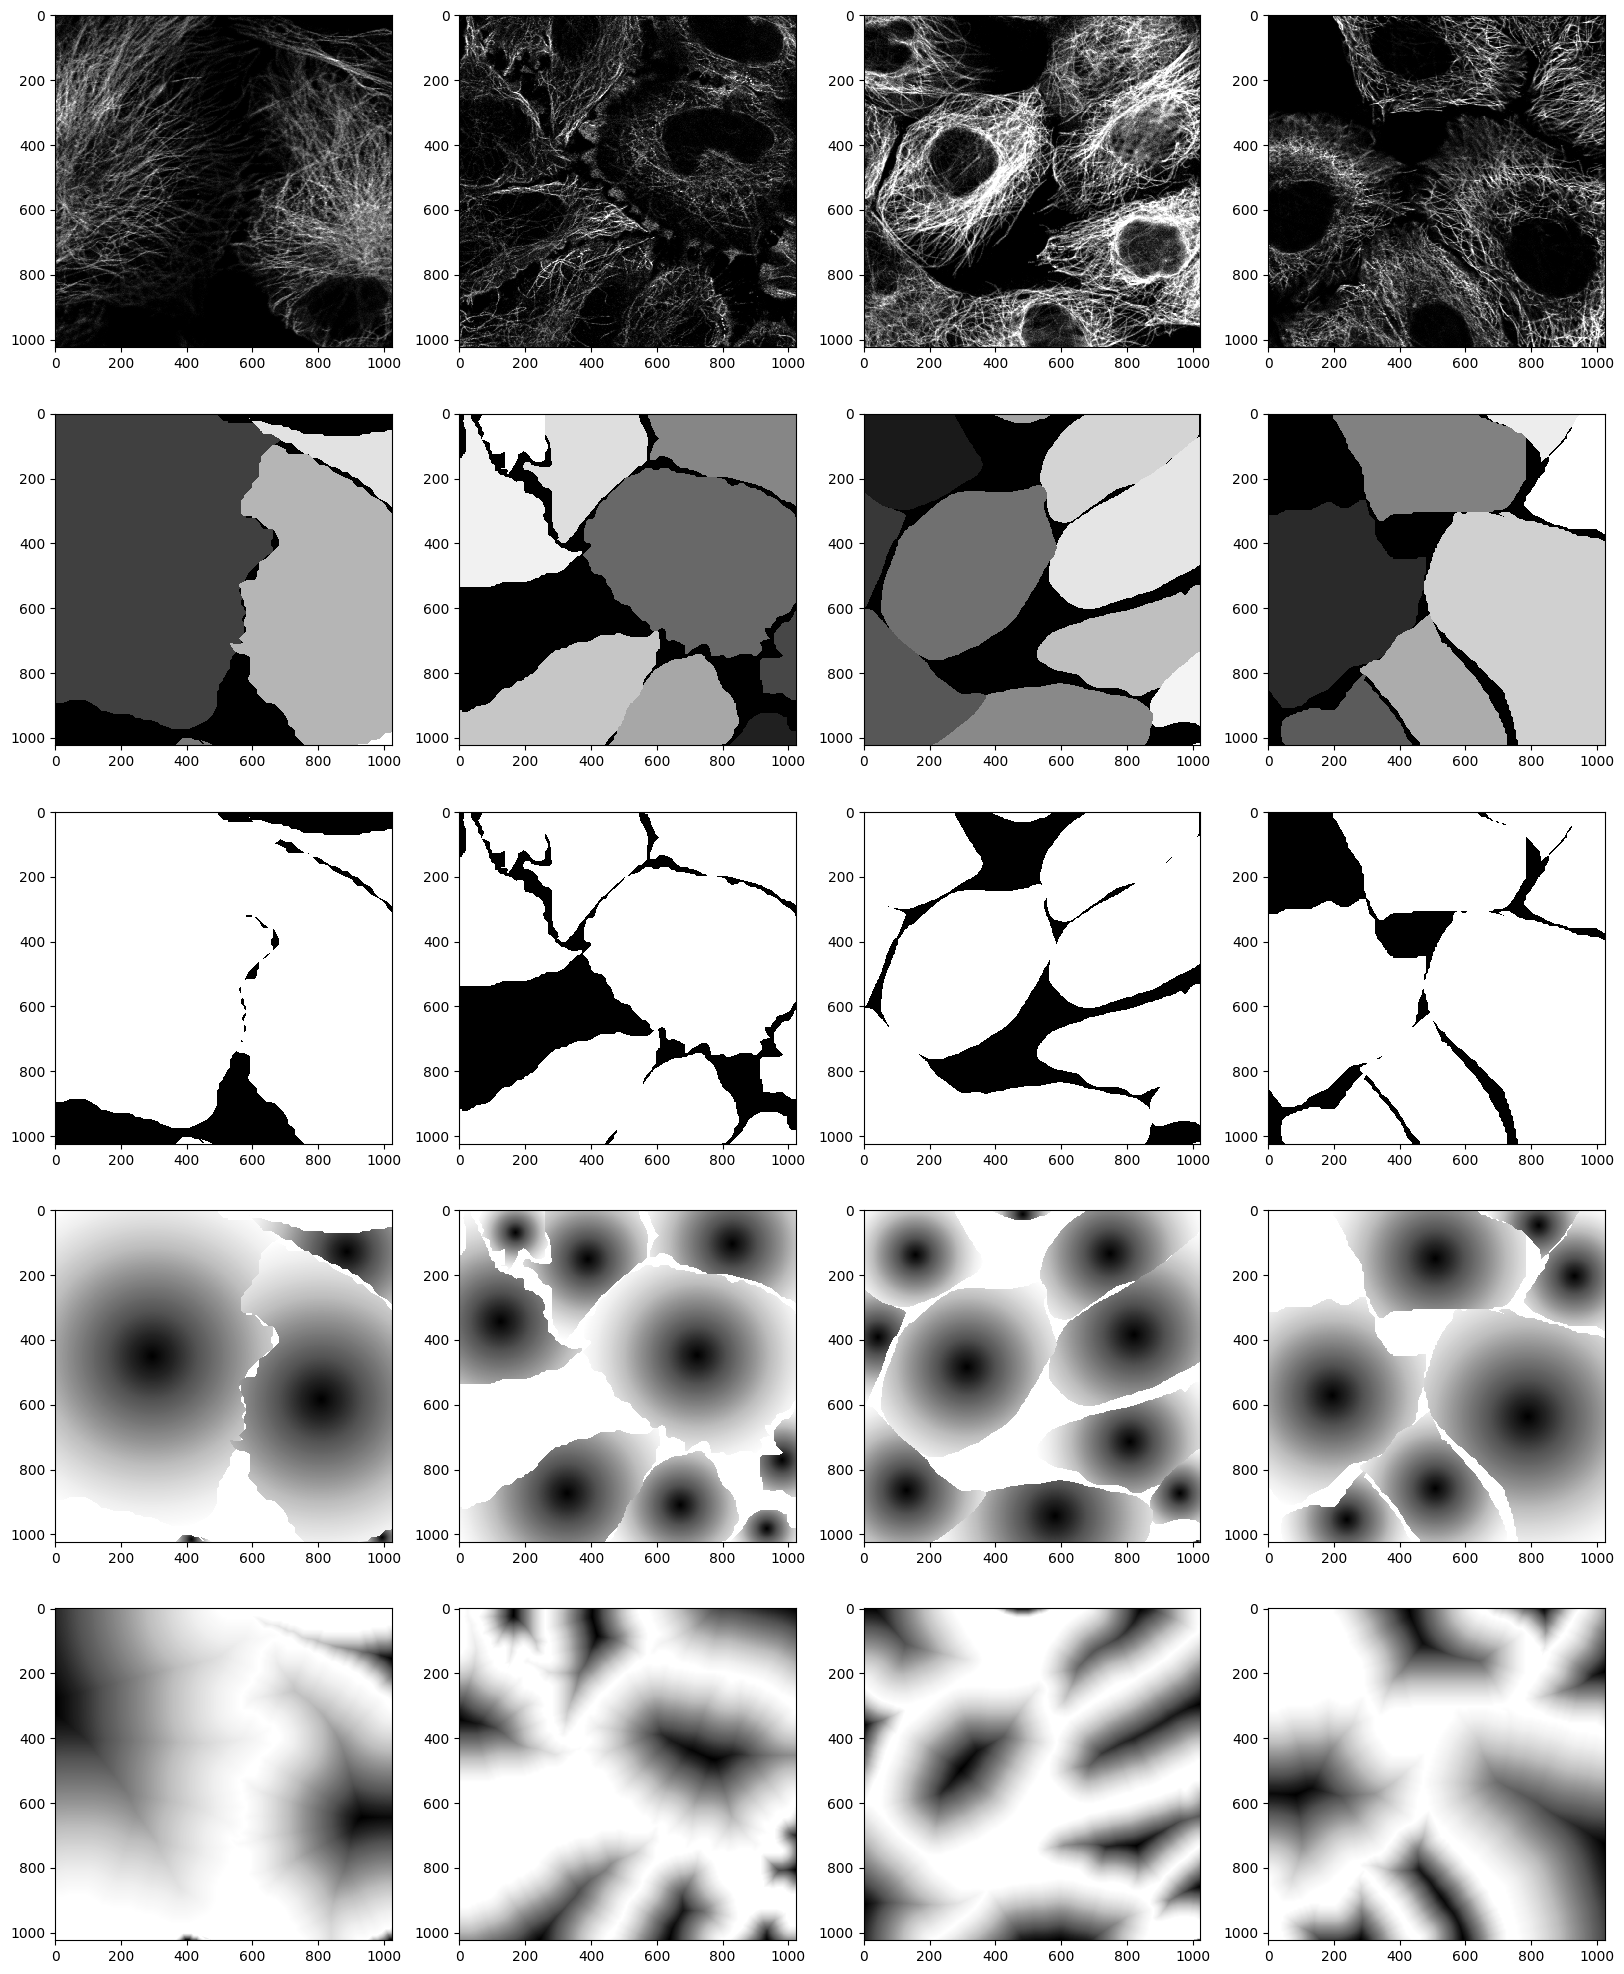

In [13]:
# Let's check how our samples lookm from the dataloader.
check_loader(train_loader, 4, plt=True)

### Run the actual model finetuning

In [14]:
# All hyperparameters for training.
n_objects_per_batch = 5  # the number of objects per batch that will be sampled
device = "cuda" if torch.cuda.is_available() else "cpu" # the device/GPU used for training
n_epochs = 5  # how long we train (in epochs)

# The model_type determines which base model is used to initialize the weights that are finetuned.
# We use vit_b here because it can be trained faster. Note that vit_h usually yields higher quality results.
model_type = "vit_b"

# The name of the checkpoint. The checkpoints will be stored in './checkpoints/<checkpoint_name>'
checkpoint_name = "sam_hpa"

**NOTE**: The user needs to decide whether to finetune the Segment Anything model, or the `µsam`'s "finetuned microscopy models" for their dataset. Here, we finetune on the Segment Anything model for simplicity. For example, if you choose to finetune the model from the light microscopy generalist models, you need to update the `model_type` to `vit_b_lm` and it takes care of initializing the model with the desired weights)

In [15]:
# Run training
sam_training.train_sam(
    name=checkpoint_name,
    save_root=os.path.join(root_dir, "models"),
    model_type=model_type,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=n_epochs,
    n_objects_per_batch=n_objects_per_batch,
    with_segmentation_decoder=train_instance_segmentation,
    device=device,
)

Verifying labels in 'val' dataloader: 100%|██████████| 50/50 [00:21<00:00,  2.35it/s]
100%|████████████████████████████████████████| 375M/375M [00:00<00:00, 278GB/s]


Start fitting for 500 iterations /  5 epochs
with 100 iterations per epoch
Training with mixed precision


Epoch 5: average [s/it]: 2.757296, current metric: 0.171352, best metric: 0.158716: 100%|█████████▉| 499/500 [41:37<00:05,  5.01s/it]  

Finished training after 5 epochs / 500 iterations.
The best epoch is number 3.
Training took 2555.6669251918793 seconds (= 00:42:36 hours)


In [16]:
# Let's spot our best checkpoint and download it to get started with the annotation tool
best_checkpoint = os.path.join("models", "checkpoints", checkpoint_name, "best.pt")

# Download link is automatically generated for the best model.
print("Click here \u2193")
FileLink(best_checkpoint)

Click here ↓


/kaggle/working/models/checkpoints/sam_hpa/best.pt

### Let's run the automatic instance segmentation (AIS)

In [23]:
def run_automatic_instance_segmentation(image, checkpoint, model_type="vit_b", device=None):
    """Automatic Instance Segmentation trained with an additional instance segmentation decoder in SAM.

    NOTE: It is supported only for `µsam` models.

    Args:
        image: The input image.
        checkpoint: Filepath to the model checkpoints.
        model_type: The choice of the `µsam` model.
        device: The torch device.

    Returns:
        The instance segmentation.
    """
    # Step 1: Get the 'predictor' and 'segmenter' to perform automatic instance segmentation.
    predictor, segmenter = get_predictor_and_segmenter(model_type=model_type, checkpoint=checkpoint, device=device, is_tiled=True)

    # Step 2: Get the instance segmentation for the given image.
    instances = automatic_instance_segmentation(
        predictor=predictor,
        segmenter=segmenter,
        input_path=image,
        ndim=2,
        tile_shape=(768, 768),
        halo=(128, 128),
    )

    return instances

Compute Image Embeddings 2D tiled.: 100%|██████████| 16/16 [00:07<00:00,  2.15it/s]


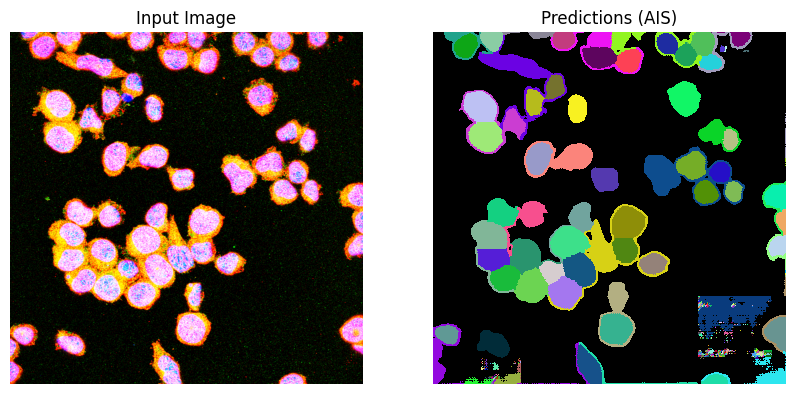

In [24]:
assert os.path.exists(best_checkpoint), "Please train the model first to run inference on the finetuned model."
assert train_instance_segmentation is True, "Oops. You didn't opt for finetuning using the decoder-based automatic instance segmentation."

for image_path in test_image_paths:
    image = imageio.imread(image_path)
    image = normalize_to_8bit(image)

    # Predicted instances
    prediction = run_automatic_instance_segmentation(
        image=image, checkpoint=best_checkpoint, model_type=model_type, device=device
    )

    # Visualize the predictions
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    ax[0].imshow(image, cmap="gray")
    ax[0].axis("off")
    ax[0].set_title("Input Image")

    ax[1].imshow(prediction, cmap=get_random_colors(prediction), interpolation="nearest")
    ax[1].axis("off")
    ax[1].set_title("Predictions (AIS)")

    plt.show()
    plt.close()

    break  # comment this out in case you want to run inference for all images.

### What next?



It's time to get started with your custom finetuned model using the annotator tool. Here is the documentation on how to get started with `µsam`: [Annotation Tools](https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#annotation-tools)



Happy annotating!

*This notebook was last ran on October 20, 2024*